In [2]:
import os
import glob
import codecs
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import interpolate




Questionnaire results


,experiment_date,trial_count,image,q1,q2,q3,q4,q5,q6,q7,q8,q9
0,0713,1,0713_1.jpg,5,5,5,5,5,4,5,5,3
1,0713,2,0713_2.jpg,3,3,3,3,3,3,3,2,3
2,0713,3,0713_3.jpg,2,2,3,2,3,3,3,2,1
3,0713,4,0713_4.jpg,2,2,3,2,3,3,2,2,2
4,0713,5,0713_5.jpg,4,4,4,4,4,4,4,4,4
5,0713,6,0713_6.jpg,5,5,5,5,5,3,5,5,4
6,0713,7,0713_7.jpg,3,4,4,4,4,3,3,3,3
7,0713,8,0713_8.jpg,2,1,2,2,2,2,3,2,1
8,0713,9,0713_9.jpg,1,1,3,2,2,3,2,1,1
9,0713,10,0713_10.jpg,4,4,4,4,4,4,4,4,4





Questionnaire contents


,q1,q2,q3,q4,q5,q6,q7,q8,q9
0,退屈な-面白い,嫌い-好き,不快-快,豊かでない-豊かである,ポジティブでない-ポジティブである,暗い-明るい,弱々しい-力強い,平凡な-独創的な,理性的な-感情的な





Oxy-Hb data


,experiment_date,time,trial_count,trial_category,ch-1,ch-2,ch-3,ch-4,ch-5,ch-6,...,ch-13,ch-14,ch-15,ch-16,ch-17,ch-18,ch-19,ch-20,ch-21,ch-22
0,0713,0.000,0,,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0713,0.150,0,,-0.010916,0.003867,0.006667,0.003237,0.002989,0.004922,...,0.008919,0.003507,0.005177,0.002709,0.007292,0.003441,0.003417,0.008807,0.006464,0.002820
2,0713,0.300,0,,0.001431,0.003377,0.007147,0.003741,0.002111,0.003658,...,0.010347,0.002795,0.005039,0.005042,0.006374,0.002175,0.002802,0.010716,0.006633,0.002474
3,0713,0.450,0,,-0.002045,0.001742,0.004772,0.002395,-0.003275,0.000927,...,0.006198,0.000844,0.003133,0.001365,0.002798,0.000594,0.000109,0.007197,0.003833,-0.000237
4,0713,0.600,0,,0.001474,0.000238,0.000823,-0.000762,-0.005549,-0.002680,...,0.000255,-0.001728,-0.001860,0.001166,-0.001348,-0.001288,-0.002298,0.002399,-0.000579,-0.002828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11582,0713,1737.300,10,questionnaire,-0.071698,-0.058509,-0.042237,0.033209,-0.065773,0.063947,...,-0.037005,-0.027884,0.006887,-0.015162,-0.029784,-0.028576,-0.009314,-0.061780,-0.001060,0.070055
11583,0713,1737.450,10,questionnaire,-0.064951,-0.058814,-0.042617,0.030935,-0.067479,0.064016,...,-0.040981,-0.027485,0.007266,-0.015991,-0.031610,-0.030835,-0.010556,-0.059402,-0.003844,0.067960
11584,0713,1737.600,10,questionnaire,-0.066047,-0.060842,-0.045839,0.026885,-0.071183,0.065581,...,-0.047664,-0.030606,0.004814,-0.017076,-0.035312,-0.032719,-0.011985,-0.054567,-0.009187,0.066070
11585,0713,1737.750,10,questionnaire,-0.073903,-0.063848,-0.049477,0.024036,-0.073848,0.067346,...,-0.053574,-0.032306,0.001804,-0.023427,-0.040371,-0.037321,-0.015537,-0.048710,-0.014751,0.063313


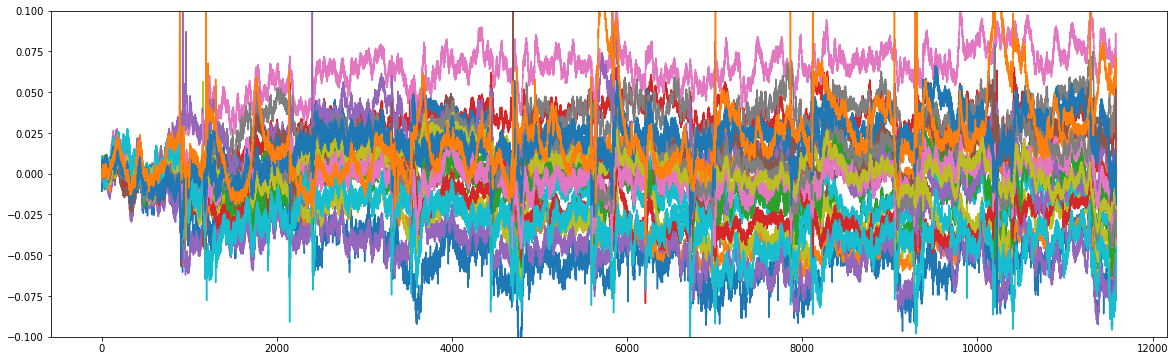

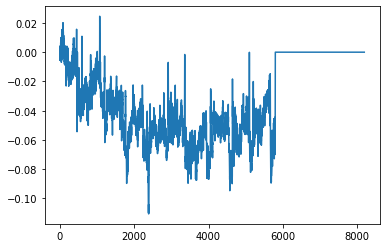

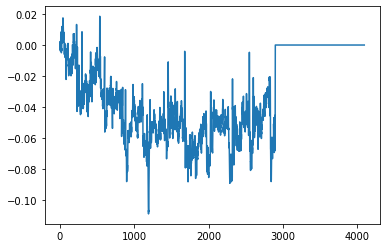

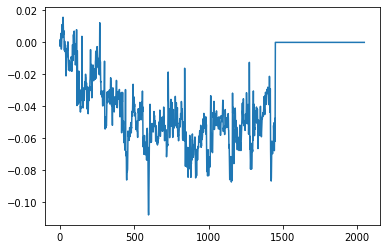

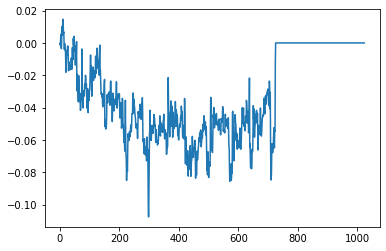

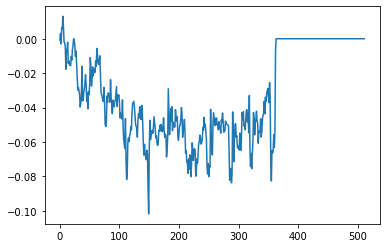

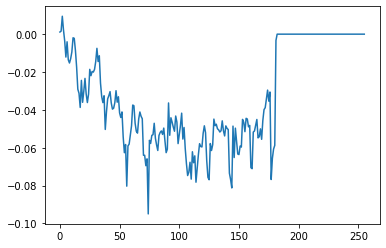

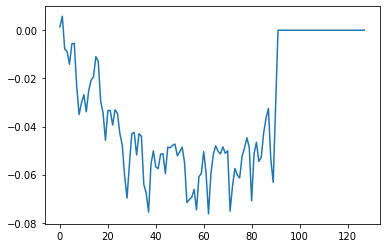

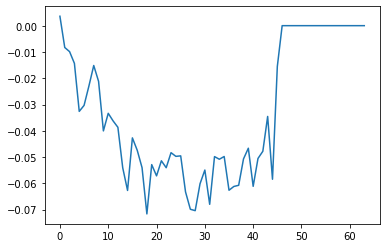

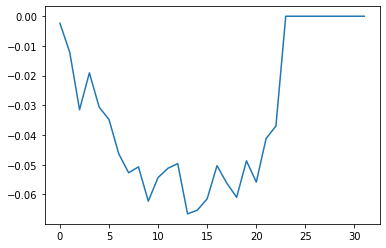

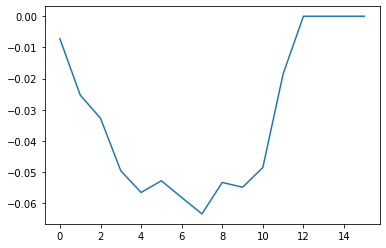

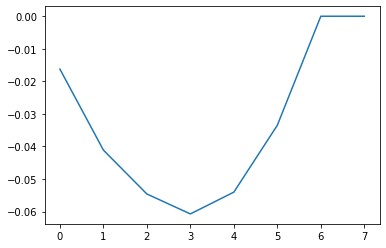

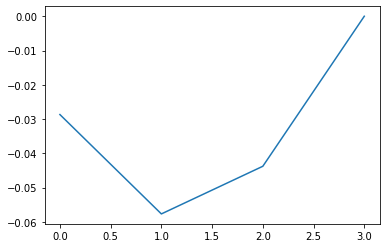

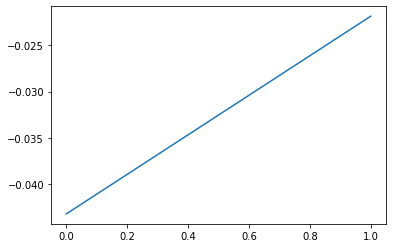

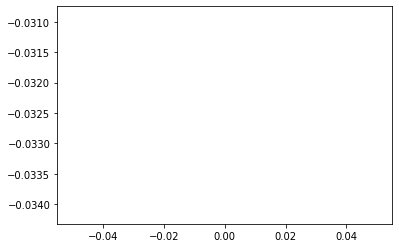




Denoised Oxy-Hb data


,experiment_date,time,trial_count,trial_category,ch-1,ch-2,ch-3,ch-4,ch-5,ch-6,...,ch-13,ch-14,ch-15,ch-16,ch-17,ch-18,ch-19,ch-20,ch-21,ch-22
0,0713,0.000,0,,-0.000866359,0.00126105,0.00388759,0.000691309,-0.00314781,0.000423162,...,0.00375752,0.000842516,0.00442691,0.00338837,0.00293045,-0.000478494,0.00111605,0.00473119,0.00302767,0.00364232
1,0713,0.150,0,,-0.000653105,0.00128414,0.00393676,0.000673562,-0.00320562,0.000426162,...,0.00370987,0.000842108,0.004446,0.00341747,0.00288282,-0.000520017,0.00109981,0.00464346,0.00304964,0.00371401
2,0713,0.300,0,,-0.000472687,0.00130784,0.00398437,0.00065636,-0.00324253,0.000439055,...,0.00366621,0.000851247,0.0044655,0.00345422,0.0028452,-0.00055347,0.0010848,0.00455636,0.00307342,0.00379348
3,0713,0.450,0,,-0.00032278,0.00133159,0.00402955,0.000639341,-0.00326137,0.000460269,...,0.00362577,0.000868515,0.00448496,0.00349733,0.00281628,-0.000580193,0.00107052,0.00446967,0.00309837,0.00387924
4,0713,0.600,0,,-0.000201058,0.00135487,0.00407146,0.000622139,-0.00326499,0.000488233,...,0.00358781,0.000892496,0.0045039,0.00354553,0.00279472,-0.000601526,0.00105645,0.00438316,0.00312385,0.00396979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11582,0713,1737.300,10,questionnaire,-0.0432255,-0.0393196,-0.0264429,0.0228069,-0.0484705,0.0207751,...,-0.0232341,-0.0165097,0.00470705,0.0029365,-0.0163599,-0.0188892,-0.0101666,-0.0493932,0.00517222,0.0445762
11583,0713,1737.450,10,questionnaire,-0.0421505,-0.038257,-0.0258075,0.0219548,-0.0472092,0.0204976,...,-0.0226831,-0.0159757,0.00449741,0.00273938,-0.0159159,-0.0184011,-0.00995795,-0.0477168,0.0050124,0.04324
11584,0713,1737.600,10,questionnaire,-0.0409274,-0.037072,-0.0250982,0.0210277,-0.0458192,0.0200363,...,-0.0220749,-0.0153937,0.00427274,0.00254988,-0.0154063,-0.0178483,-0.00972339,-0.0459425,0.00485973,0.0417559
11585,0713,1737.750,10,questionnaire,-0.0395905,-0.0357937,-0.024329,0.0200511,-0.0443306,0.0194256,...,-0.0214163,-0.0147746,0.00403935,0.00237558,-0.0148431,-0.0172446,-0.00946834,-0.0441061,0.00471858,0.0401638


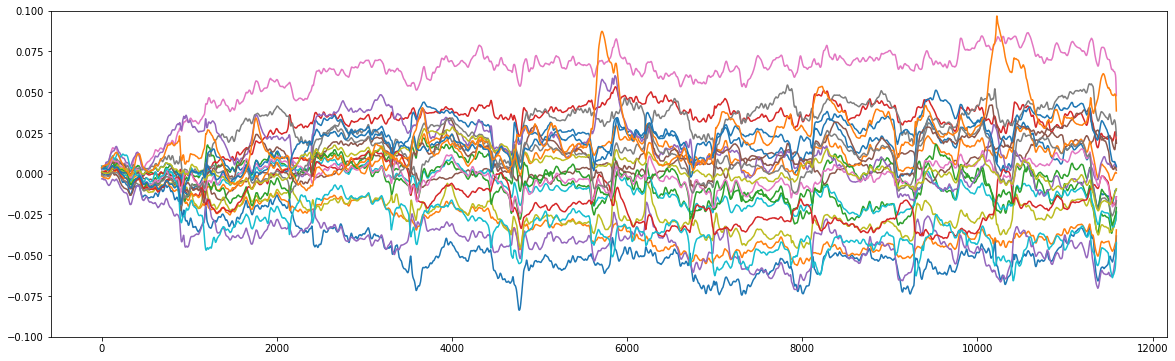




Trial count -> 1


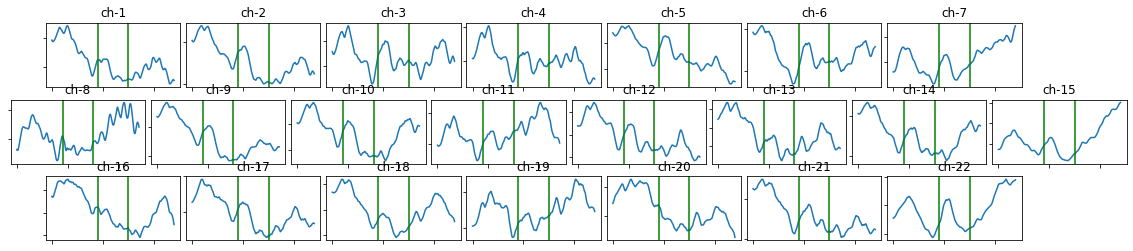

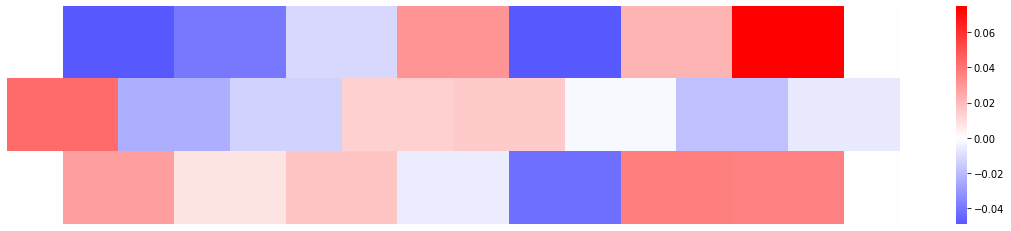




Trial count -> 2


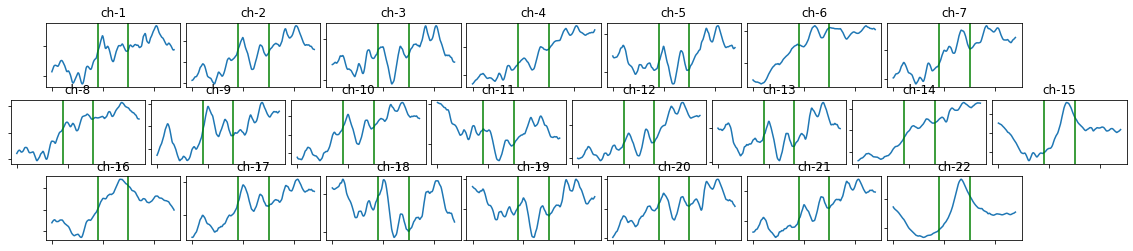

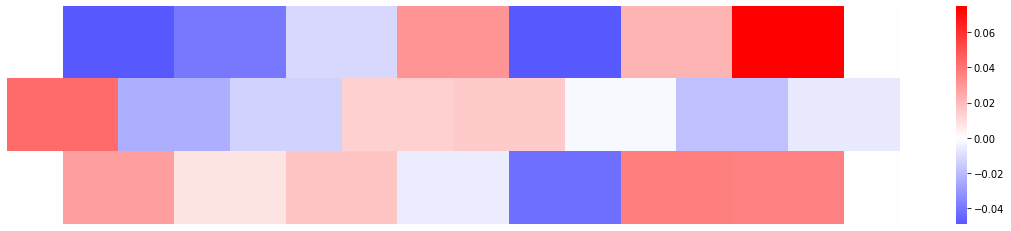




Trial count -> 3


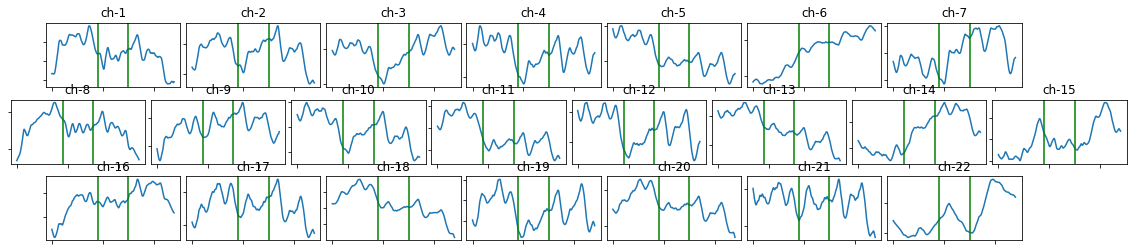

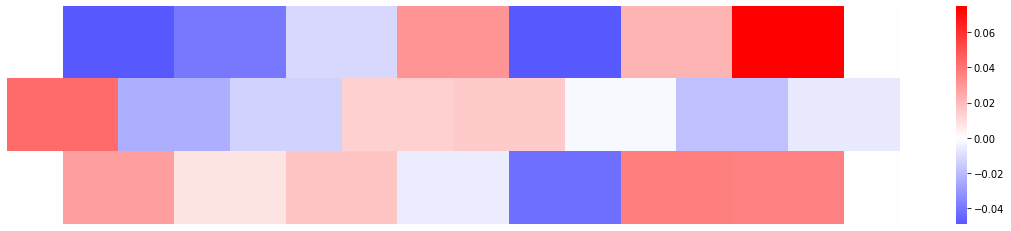




Trial count -> 4


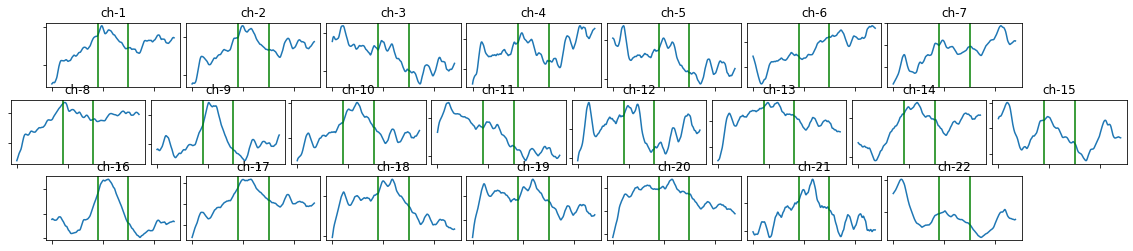

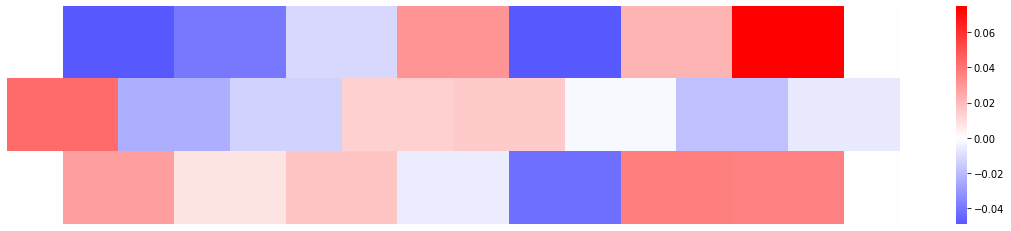




Trial count -> 5


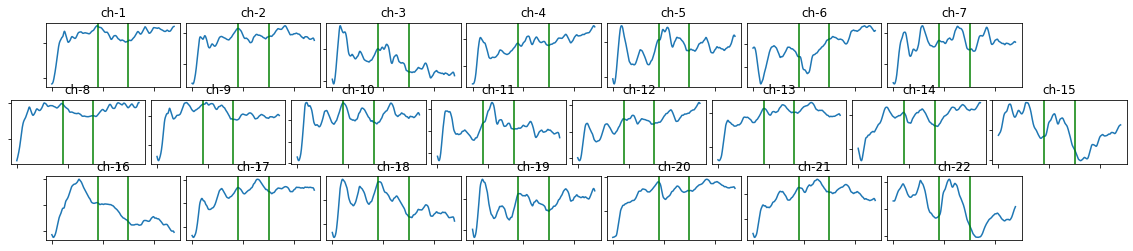

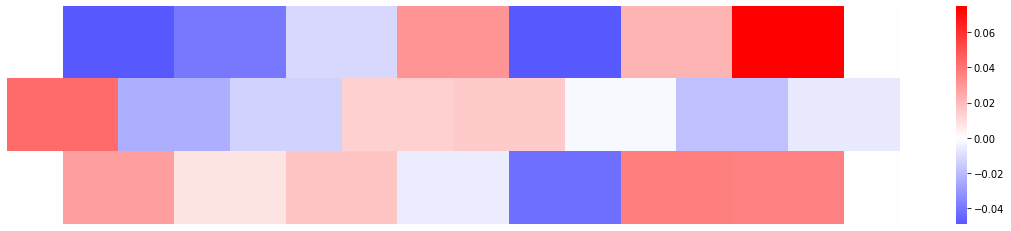




Trial count -> 6


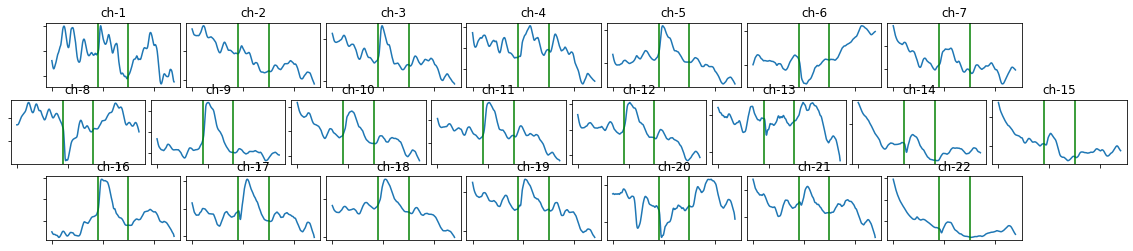

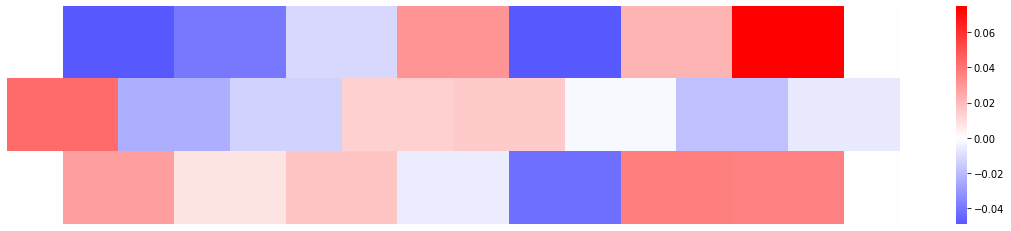




Trial count -> 7


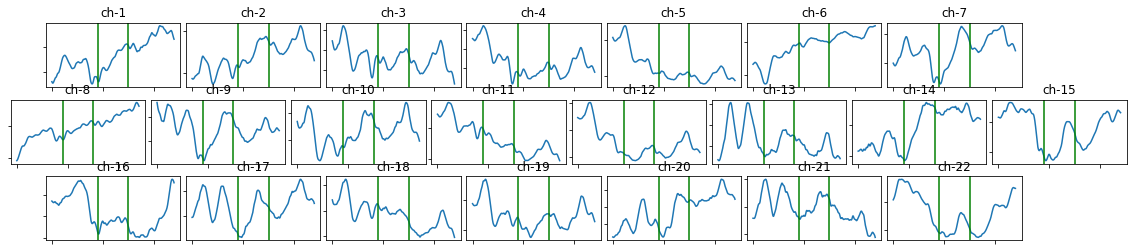

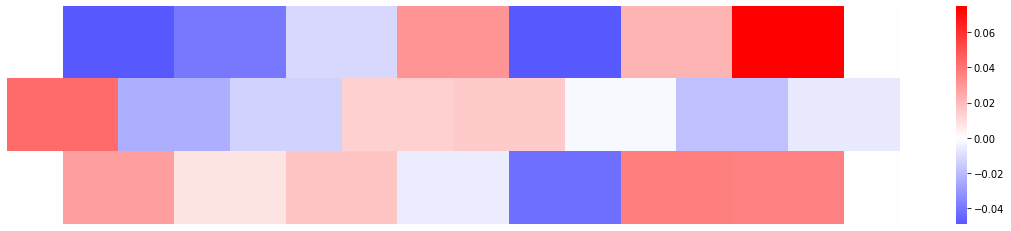




Trial count -> 8


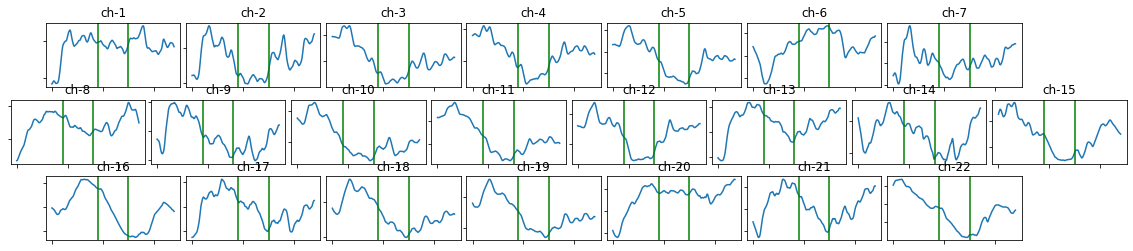

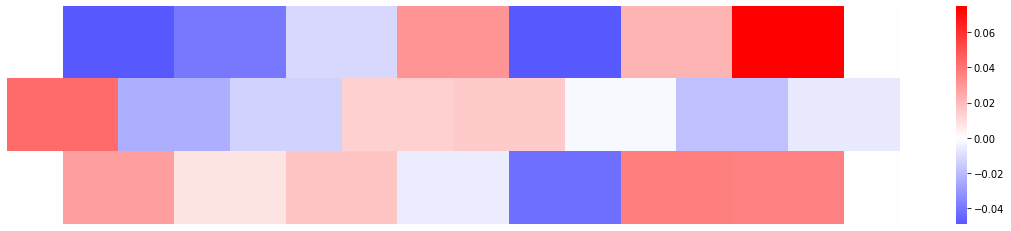




Trial count -> 9


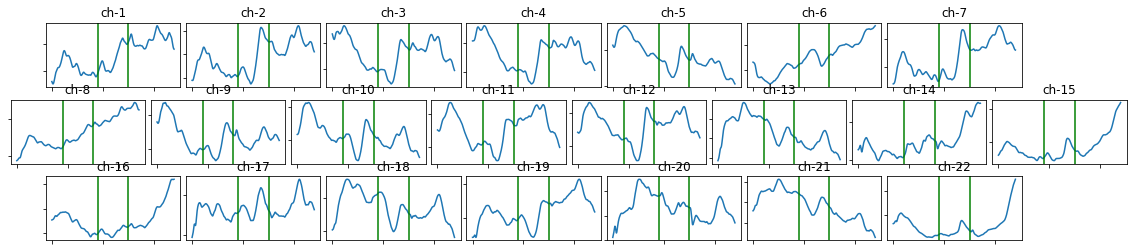

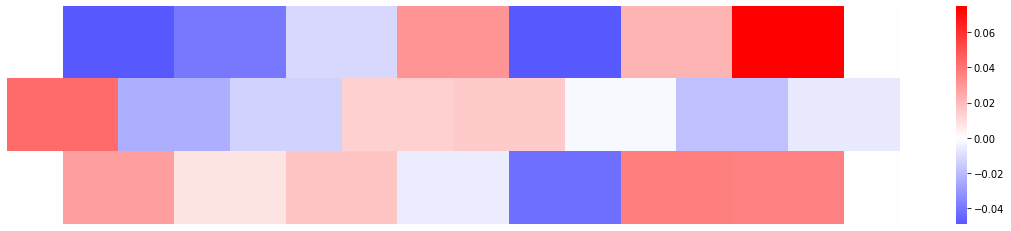




Trial count -> 10


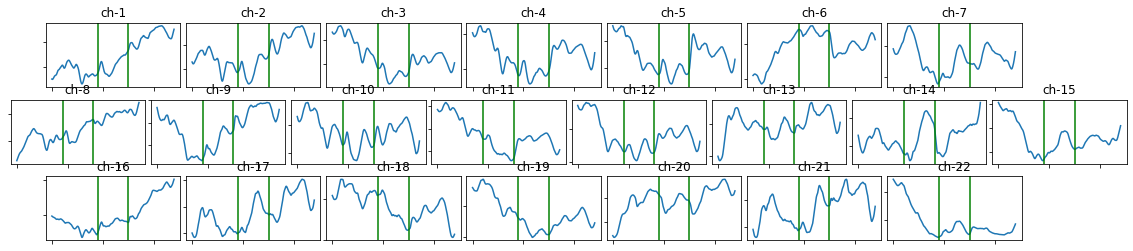

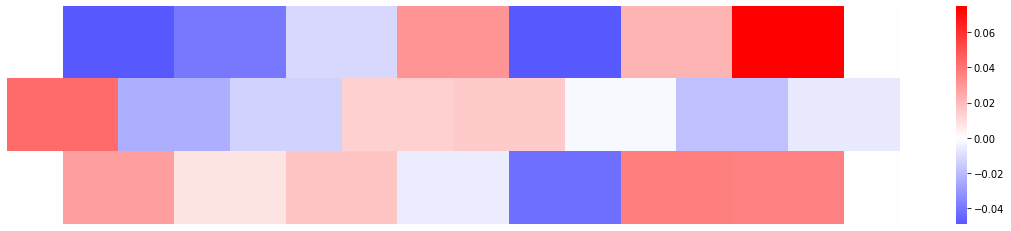




Z-normalized Oxy-Hb data


,experiment_date,time,trial_count,trial_category,ch-1,ch-2,ch-3,ch-4,ch-5,ch-6,...,ch-13,ch-14,ch-15,ch-16,ch-17,ch-18,ch-19,ch-20,ch-21,ch-22
0,0713,54.450,1,task,-0.898836,-0.90009,-0.903019,-0.906333,-0.908742,-0.908955,...,-0.881183,-0.888379,-0.902052,-0.92116,-0.943835,-0.968208,-0.992409,-1.01457,-1.03282,-1.04528
1,0713,54.600,1,task,-1.05037,-1.04839,-1.04046,-1.02772,-1.01132,-0.992371,...,-0.867043,-0.855745,-0.84684,-0.840556,-0.837053,-0.836003,-0.836862,-0.839081,-0.842113,-0.845412
2,0713,54.750,1,task,-0.848429,-0.850619,-0.851507,-0.851134,-0.849749,-0.847605,...,-0.83233,-0.832892,-0.834725,-0.838009,-0.842923,-0.849649,-0.858377,-0.869393,-0.883022,-0.899588
3,0713,54.900,1,task,-0.919415,-0.942827,-0.97015,-1.00171,-1.03774,-1.07787,...,-1.41615,-1.46493,-1.51262,-1.55908,-1.60418,-1.64776,-1.68968,-1.7298,-1.76799,-1.80431
4,0713,55.050,1,task,-1.83893,-1.87205,-1.90389,-1.93464,-1.96449,-1.99366,...,-2.16053,-2.17366,-2.18278,-2.18798,-2.18959,-2.18796,-2.18343,-2.17633,-2.167,-2.15579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0713,1644.750,10,task,-0.943997,-0.925921,-0.905571,-0.883455,-0.860116,-0.836097,...,-0.689875,-0.674468,-0.660074,-0.64648,-0.633394,-0.620514,-0.607765,-0.595406,-0.583725,-0.573009
1996,0713,1644.900,10,task,-0.563545,-0.555621,-0.549523,-0.545534,-0.543644,-0.543412,...,-0.549059,-0.546748,-0.543788,-0.540488,-0.537158,-0.53411,-0.531652,-0.530093,-0.529635,-0.530322
1997,0713,1645.050,10,task,-0.532184,-0.53525,-0.539551,-0.545113,-0.55195,-0.560071,...,-0.636046,-0.646542,-0.656381,-0.665827,-0.67517,-0.684699,-0.694705,-0.705476,-0.717294,-0.730436
1998,0713,1645.200,10,task,-0.744967,-0.760623,-0.777113,-0.794143,-0.811421,-0.828656,...,-0.934566,-0.948393,-0.962339,-0.976568,-0.991113,-1.00581,-1.02046,-1.03488,-1.04889,-1.06229





Oxy-Hb mean with questionnaire results


,trial_count,ch-1,ch-2,ch-3,ch-4,ch-5,ch-6,ch-7,ch-8,ch-9,...,image,q1,q2,q3,q4,q5,q6,q7,q8,q9
0,1,-1.637764,-1.667840,-0.253645,-0.567567,-0.719453,-0.270887,-0.165940,-1.163078,-1.849684,...,0713_1.jpg,5,5,5,5,5,4,5,5,3
1,2,2.872368,2.040982,0.456449,3.276370,-0.192306,2.293689,4.417419,3.434882,2.138957,...,0713_2.jpg,3,3,3,3,3,3,3,2,3
2,3,-1.101503,-0.580028,-2.133663,-2.115974,-3.052623,3.387911,1.238639,-0.380475,0.746860,...,0713_3.jpg,2,2,3,2,3,3,3,2,1
3,4,1.585252,1.760254,-1.501073,0.681192,-0.448423,1.608761,1.356176,1.179132,3.049988,...,0713_4.jpg,2,2,3,2,3,3,2,2,2
4,5,0.298578,0.560031,-0.263218,1.146788,1.206069,0.017647,0.619899,0.044069,0.544624,...,0713_5.jpg,4,4,4,4,4,4,4,4,4
5,6,-0.370392,-2.267713,-0.624360,0.443822,3.147706,-2.153673,-0.456260,-3.920570,5.690676,...,0713_6.jpg,5,5,5,5,5,3,5,5,4
6,7,0.971925,2.145266,-0.506830,-1.234667,-1.514042,1.654923,0.372332,1.228314,-0.451869,...,0713_7.jpg,3,4,4,4,4,3,3,3,3
7,8,0.116061,-1.737968,-2.514610,-2.958924,-4.138124,1.912729,-0.926882,-0.183817,-1.589946,...,0713_8.jpg,2,1,2,2,2,2,3,2,1
8,9,1.217186,0.744642,-0.869235,-0.905524,-1.915096,2.185977,1.040093,1.596740,-0.739969,...,0713_9.jpg,1,1,3,2,2,3,2,1,1
9,10,1.084281,-0.791032,-2.496945,-1.602583,-1.313907,1.469099,-0.623469,1.119629,-0.244026,...,0713_10.jpg,4,4,4,4,4,4,4,4,4





Correlations between questionnaire results and Oxy-Hb mean values


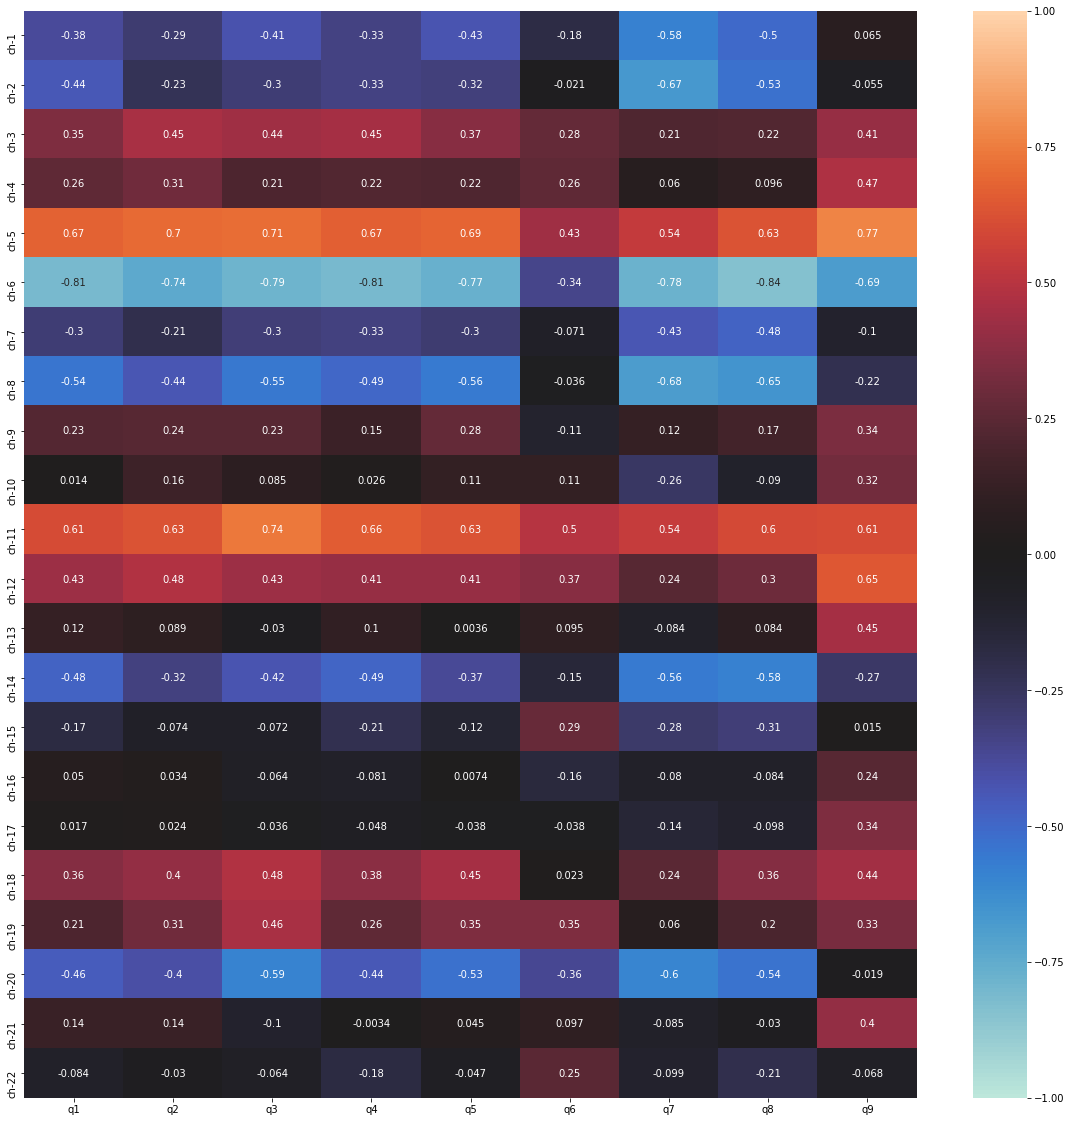




Oxy-Hb variations(task start - task end) with questionnaire results


,trial_count,ch-1,ch-2,ch-3,ch-4,ch-5,ch-6,ch-7,ch-8,ch-9,...,image,q1,q2,q3,q4,q5,q6,q7,q8,q9
0,1,-1.260661,-2.171955,-0.323604,-0.322419,-0.895605,0.274614,0.271416,-0.497543,-2.089396,...,0713_1.jpg,5,5,5,5,5,4,5,5,3
1,2,0.178146,-0.429177,-0.752337,2.655646,-0.952879,1.343105,2.518338,1.284733,-0.579695,...,0713_2.jpg,3,3,3,3,3,3,3,2,3
2,3,0.395359,2.614835,2.838849,2.010817,0.337658,1.217556,5.702425,-0.495657,2.024367,...,0713_3.jpg,2,2,3,2,3,3,3,2,1
3,4,-0.988685,-1.069119,-2.776161,-2.150228,-2.457889,2.137864,-0.140191,-1.210514,-3.289011,...,0713_4.jpg,2,2,3,2,3,3,2,2,2
4,5,-1.104666,-0.657083,-1.775223,-0.189388,-0.840861,1.675699,-0.687903,-0.882908,-0.989013,...,0713_5.jpg,4,4,4,4,4,4,4,4,4
5,6,-2.026863,-2.037983,-0.765114,1.018313,-2.147740,-0.088529,-0.515269,-0.564045,-3.481995,...,0713_6.jpg,5,5,5,5,5,3,5,5,4
6,7,4.116626,3.191956,0.367791,0.677893,0.021155,0.041697,3.308797,2.286581,2.421459,...,0713_7.jpg,3,4,4,4,4,3,3,3,3
7,8,-0.149649,0.234698,0.145978,0.069894,-2.213978,1.067301,-0.283298,-0.950249,-1.293103,...,0713_8.jpg,2,1,2,2,2,2,3,2,1
8,9,3.748415,3.644407,1.345722,1.349377,-0.093633,1.314629,3.706385,3.704466,0.811555,...,0713_9.jpg,1,1,3,2,2,3,2,1,1
9,10,3.732191,1.863937,-0.324839,0.272000,0.203460,-0.132859,1.063280,2.389301,1.602757,...,0713_10.jpg,4,4,4,4,4,4,4,4,4





Correlations between questionnaire results and Oxy-Hb variations(task start - task end)


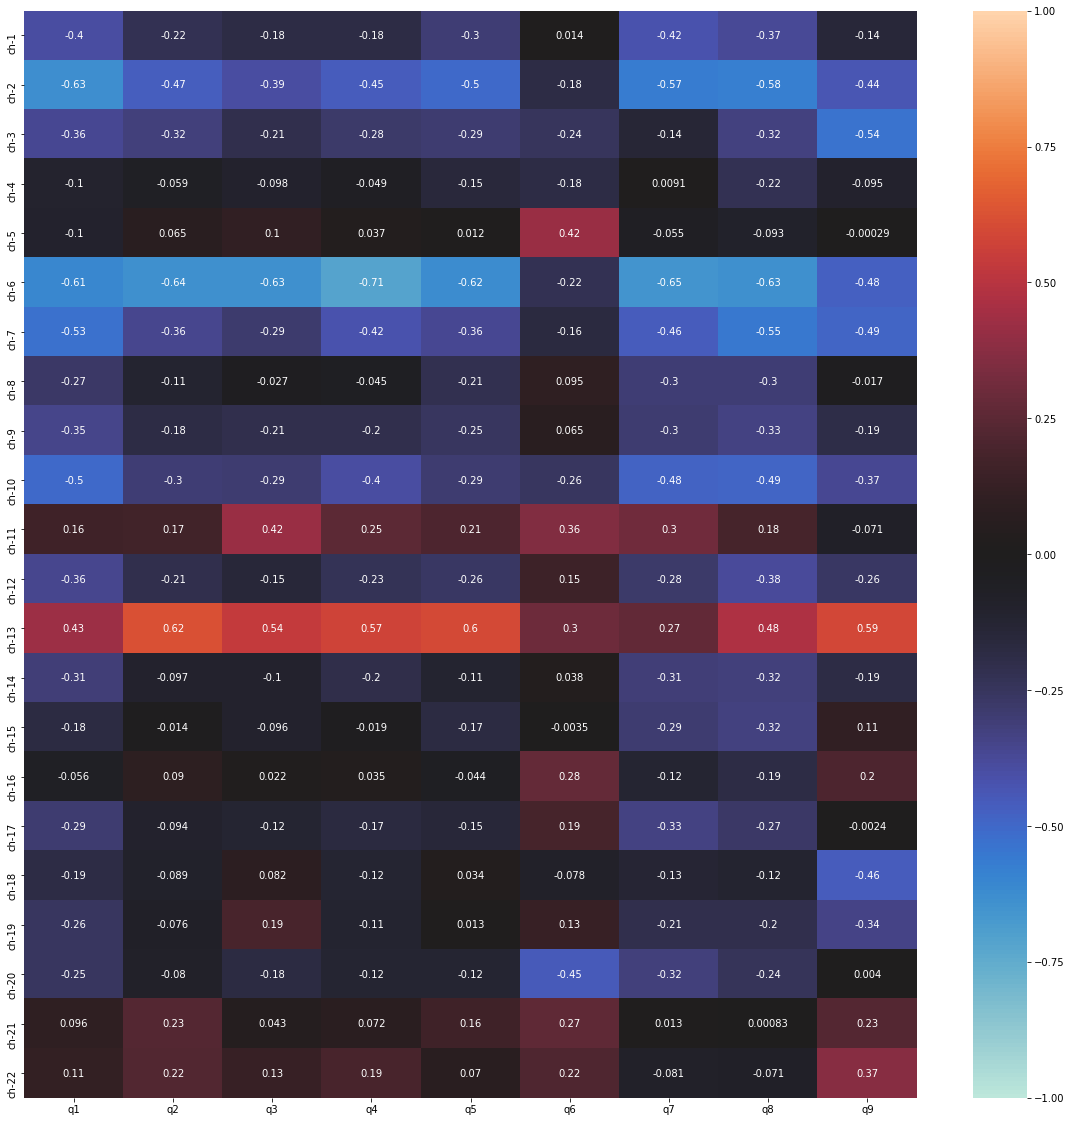

In [56]:
# define constants.
measurement_period = 0.15     # [sec]
preceding_rest_duration = 45  # [sec]
task_duration = 30            # [sec]
following_rest_duration = 45  # [sec]
num_preceding_rest_samples = int(preceding_rest_duration/measurement_period)
num_task_samples = int(task_duration/measurement_period)
num_following_rest_samples = int(following_rest_duration/measurement_period)
num_trial_samples = num_preceding_rest_samples + num_task_samples + num_following_rest_samples
num_columns = 70
separation_char = '\t'
data_table_start_row_index = 33
num_channels = 22
nirs_data_filepath = './experimental_data/nirs/0713-main.TXT'
questionnaire_data_filepath = './experimental_data/questionnaire/0713.csv'
experiment_date = os.path.splitext(os.path.basename(nirs_data_filepath))[0].split('-')[0]

# load nirs data and make (temporary) dataframe object
temporary_names = np.arange(num_columns).astype(str)
temporary_df = pd.read_csv(
    nirs_data_filepath, 
    names=temporary_names, 
    sep=separation_char, 
    low_memory=False
)

# load questionnare data and create dataframe object
questionnaire_result_df = pd.read_csv(
    questionnaire_data_filepath, 
    index_col=0, 
)
questionnaire_contents = questionnaire_result_df.columns.values[1:]
questionnaire_result_df.insert(0, 'trial_count', (np.arange(len(questionnaire_result_df))+1).astype(str))
questionnaire_result_df.insert(0, 'experiment_date', (np.full(len(questionnaire_result_df), experiment_date)))
questionnaire_ids = ['q{}'.format(i+1) for i in range(questionnaire_contents.shape[0])]
mapper = {}
for questionnaire_content, questionnaire_id in zip(questionnaire_contents, questionnaire_ids):
    mapper[questionnaire_content] = questionnaire_id
questionnaire_result_df = questionnaire_result_df.rename(columns=mapper)
questionnaire_content_df = pd.DataFrame(
    np.expand_dims(questionnaire_contents, axis=0), 
    columns=questionnaire_ids
)
print('\n\n\nQuestionnaire results')
display(questionnaire_result_df)
print('\n\n\nQuestionnaire contents')
display(questionnaire_content_df)

# create dataframe object that contains oxy-hb data
oxy_data = temporary_df[[temporary_names[0], temporary_names[2], *temporary_names[4::3]]][data_table_start_row_index:].values
channel_names = [label.replace(' ', '') for label in oxy_data[0][2:]]
oxy_df_column_labels = [*oxy_data[1][:2], *channel_names]
oxy_df = pd.DataFrame(
    oxy_data[2:],
    columns=oxy_df_column_labels
)
cast_dict = {}
for channel_name in channel_names:
    cast_dict[channel_name] = float
oxy_df = oxy_df.astype(cast_dict)
# find marker indexes
finding_marker_query_statement = 'Mark !=0 and Mark !="0"'
marker_indexes = oxy_df.query(finding_marker_query_statement).index.values
marker_differences = marker_indexes[1:] - marker_indexes[:-1]
valid_marker_boolean_indexes = [*(marker_differences > num_trial_samples), True]
marker_indexes = marker_indexes[valid_marker_boolean_indexes]
num_trials = marker_indexes.shape[0]
# add two columns('trial_count', 'trial_category') to oxy_df
# with this operation, you can access data easily 
trial_counts = np.zeros(len(oxy_df))
trial_categories = np.full(len(oxy_df), '', dtype=object)
for i, marker_index in enumerate(marker_indexes):
    trial_counts[marker_index:] = i+1
    trial_categories[marker_index:marker_index+num_preceding_rest_samples] = 'preceding_rest'
    trial_categories[marker_index+num_preceding_rest_samples:marker_index+num_preceding_rest_samples+num_task_samples] = 'task'
    trial_categories[marker_index+num_preceding_rest_samples+num_task_samples:marker_index+num_preceding_rest_samples+num_task_samples+num_following_rest_samples] = 'following_rest'
    trial_categories[marker_index+num_preceding_rest_samples+num_task_samples+num_following_rest_samples:] = 'questionnaire'
oxy_df.insert(1, 'trial_count', trial_counts.astype(int))
oxy_df.insert(2, 'trial_category', trial_categories)
oxy_df = oxy_df.drop('Mark', axis=1)
oxy_df = oxy_df.rename(columns={'Time(sec)': 'time'})
oxy_df.insert(0, 'experiment_date', (np.full(len(oxy_df), experiment_date)))
print('\n\n\nOxy-Hb data')
display(oxy_df)
plt.figure(figsize=(20,6))
plt.plot(oxy_df[channel_names].values)
plt.ylim(-0.1, 0.1)
plt.show()

# denoise data using multi resolution analysis
# note that changing value of 'minimum_frequency' or 'maximum_frequency' will make changes in results
oxy_df_column_labels = oxy_df.columns.values
num_information_columns = 4
info_labels = oxy_df_column_labels[:num_information_columns]
oxy_value_labels = oxy_df_column_labels[num_information_columns:]
info_values = oxy_df[info_labels].values
oxy_values = oxy_df[oxy_value_labels].values.astype(float).T
num_paddings = 2**14-oxy_values.shape[1]
wavelet_input = np.pad(oxy_values, [(0,0),(0,num_paddings)])
count = 0
period = 0.15  # [sec]
frequency = 1/period  # [Hz]
denoised_oxy_values = np.zeros(wavelet_input.shape)
resample_x = np.linspace(0, wavelet_input.shape[1], wavelet_input.shape[1])
add_count = 0
minimum_frequency = 0.004  # [Hz]
maximum_frequency = 1    # [Hz]
while wavelet_input.shape[1] > 1:
    count += 1
    period *= 2
    frequency = 1/period
    wavelet_output = wavelet_input[:, 0::2] + (wavelet_input[:, 1::2] - wavelet_input[:, 0::2])/2
    wavelet_input = wavelet_output
    if minimum_frequency < frequency and frequency < maximum_frequency:
        resampled_wavelet_output = np.zeros(denoised_oxy_values.shape)
        for i, wavelet_output_per_channel in enumerate(wavelet_output):
            x = np.linspace(0, resample_x.shape[0], wavelet_output_per_channel.shape[0])
            interpolated_wavelet_output_per_channel = interpolate.interp1d(x, wavelet_output_per_channel, kind='cubic')
            resampled_wavelet_output[i] = interpolated_wavelet_output_per_channel(resample_x)
        denoised_oxy_values += resampled_wavelet_output
        add_count += 1
    plt.plot(wavelet_output[0])
    plt.show()
denoised_oxy_values = np.hstack([info_values, denoised_oxy_values.T[:-num_paddings]/add_count])
denoised_oxy_df = pd.DataFrame(
    denoised_oxy_values,
    columns=oxy_df_column_labels
)
print('\n\n\nDenoised Oxy-Hb data')
display(denoised_oxy_df)
plt.figure(figsize=(20,6))
plt.plot(denoised_oxy_df[channel_names].values)
plt.ylim(-0.1, 0.1)
plt.show()

# for each trial, normalize task samples using rest samples and create dataframe.
normalized_task_samples_list = []
means_list = []
variations_list = []
task_infomations_list = []
for trial_count in range(1, num_trials+1):
    query_statement = 'trial_count == {}'.format(trial_count)
    oxy_df_while_trial = denoised_oxy_df.query(query_statement)
    query_statement = 'trial_count == {} and trial_category == "preceding_rest"'.format(trial_count)
    oxy_df_while_preseding_rest = denoised_oxy_df.query(query_statement)
    query_statement = 'trial_count == {} and trial_category == "task"'.format(trial_count)
    oxy_df_while_task = denoised_oxy_df.query(query_statement)
    task_infomations = oxy_df_while_task[info_labels].values
    task_infomations_list.append(task_infomations)
    task_samples = oxy_df_while_task[oxy_value_labels].values.astype(float).T
    rest_samples = oxy_df_while_preseding_rest[oxy_value_labels].values.astype(float).T
    rest_sample_means = np.mean(rest_samples, axis=1)
    rest_sample_stds = np.std(rest_samples, axis=1)
    task_sample_means = np.mean(task_samples, axis=1)
    task_sample_stds = np.std(task_samples, axis=1)
    normalized_task_samples = np.zeros(task_samples.shape)
    for i in range(task_samples.shape[0]):
        normalized_task_samples[i] = (task_samples[i]-rest_sample_means[i])/rest_sample_stds[i]
    normalized_task_samples_list.append(normalized_task_samples)
    means_list.append(np.mean(normalized_task_samples, axis=1))
    variations = normalized_task_samples[:, -1] - normalized_task_samples[:, 0]
    variations_list.append(variations)

    # visualize data
    print('\n\n\nTrial count -> {}'.format(trial_count))
    fig = plt.figure(figsize=(20,4))
    second_row_start_index = 7
    third_row_start_index = 15
    num_colspans = 4
    num_rows = 3
    num_columns = int(num_colspans*np.ceil(num_channels/num_rows))
    for i, channel_label in enumerate(oxy_value_labels):
        samples = oxy_df_while_trial[channel_label].values[:num_trial_samples]
        times = np.linspace(0, 120, samples.shape[0])
        if i < second_row_start_index :
            ax = plt.subplot2grid((num_rows, num_columns), (0, num_colspans*i+1), rowspan=1, colspan=num_colspans)
        elif second_row_start_index <= i and i <= 14:
            ax = plt.subplot2grid((num_rows, num_columns), (1, num_colspans*(i-second_row_start_index)), rowspan=1, colspan=num_colspans)
        elif third_row_start_index <= i:
            ax = plt.subplot2grid((num_rows, num_columns), (2, num_colspans*(i-third_row_start_index)+1), rowspan=1, colspan=num_colspans)
        ax.plot(times, samples)
        ax.axvline(x=times[num_preceding_rest_samples], color='green')
        ax.axvline(x=times[num_preceding_rest_samples+num_task_samples], color='green')
        ax.set_title(channel_label)
        ax.tick_params(
            labelbottom=False,
            labelleft=False,
            labelright=False,
            labeltop=False
        )
    plt.show()
    reshaped_means = np.zeros([3, 16])
    reshaped_means[0,1:15:2] = means[:7]
    reshaped_means[0,2:16:2] = means[:7]
    reshaped_means[1,0::2] = means[7:15]
    reshaped_means[1,1::2] = means[7:15]
    reshaped_means[2,1:15:2] = means[15:]
    reshaped_means[2,2:16:2] = means[15:]
    plt.figure(figsize=(20,4))
    plt.axis("off")
    sns.heatmap(reshaped_means, center=0, cmap='bwr')
    plt.show()

normalized_task_samples_array = np.reshape(np.array(normalized_task_samples_list), [num_task_samples*num_trials, num_channels])
task_infomations_array = np.reshape(np.array(task_infomations_list), [num_task_samples*num_trials, num_information_columns])
normalized_task_sample_df = pd.DataFrame(
    np.hstack([task_infomations_array, normalized_task_samples_array]),
    columns=oxy_df_column_labels
)
print('\n\n\nZ-normalized Oxy-Hb data')
display(normalized_task_sample_df)

# calculate correlations between questionnaire results and Oxy-Hb mean values
means_array = np.array(means_list).astype(float)
mean_df = pd.DataFrame(
    means_array,
    columns=oxy_value_labels
)
mean_df.insert(0, 'trial_count', (np.arange(len(questionnaire_result_df))+1).astype(str))
mean_with_questionnaire_result_df = pd.merge(mean_df, questionnaire_result_df, on='trial_count')
print('\n\n\nOxy-Hb mean with questionnaire results')
display(mean_with_questionnaire_result_df)
print('\n\n\nCorrelations between questionnaire results and Oxy-Hb mean values')
questionnaire_and_mean_correlations = mean_with_questionnaire_result_df.corr().loc[oxy_value_labels,questionnaire_ids]
plt.figure(figsize=(20,20))
sns.heatmap(questionnaire_and_mean_correlations, vmax=1, vmin=-1, center=0, annot=True)
plt.show()

# calculate correlation between questionnaire results and Oxy-Hb variations(task start - task end)
variations_array = np.array(variations_list).astype(float)
variation_df = pd.DataFrame(
    variations_array,
    columns=oxy_value_labels
)
variation_df.insert(0, 'trial_count', (np.arange(len(variation_df))+1).astype(str))
variation_with_questionnaire_result_df = pd.merge(variation_df, questionnaire_result_df, on='trial_count')
print('\n\n\nOxy-Hb variations(task start - task end) with questionnaire results')
display(variation_with_questionnaire_result_df)
print('\n\n\nCorrelations between questionnaire results and Oxy-Hb variations(task start - task end)')
questionnaire_and_variation_correlations = variation_with_questionnaire_result_df.corr().loc[oxy_value_labels,questionnaire_ids]
plt.figure(figsize=(20,20))
sns.heatmap(questionnaire_and_variation_correlations, vmax=1, vmin=-1, center=0, annot=True)
plt.show()
    